# Otimização Estocástica

O objetivo deste tutorial é demonstrar como modelar e resolver um
programa estocástico de dois estágios.
Com isto, iremos também explorar:
- Conjuntos gerais de índices, tanto para variáveis como restrições no `JuMP`,
- Composição de modelos, através de variáveis auxiliares,
- A introdução de expressões intermediárias, para facilitar a leitura do código.


Este tutorial utiliza os seguintes pacotes:

In [1]:
using JuMP
import Distributions
import HiGHS
import Plots
import StatsPlots
import Statistics

## O problema da fábrica de tortas

Você decidiu abrir um negócio vendendo tortas no final de semana.
Após algumas semanas, ficou claro que operar um negócio de alimentos não é tão fácil assim:
- As tortas devem ser preparadas de manhã, _antes_ de abrir a loja e poder avaliar a demanda.
- Se você assar muitas tortas, elas não vendidas e ao final do dia devem ser descartadas:  você terá desperdiçado tempo e dinheiro em sua produção.
- Mas se assar poucas, pode haver clientes não atendidos e você poderia ter lucrado mais se assasse mais tortas.

Após algumas semanas sem um plano claro, você decide colocar seu conhecimento de
Pesquisa Operacional em prática, começando com a **coleta de dados**.
- Cada torta custa \$2 para ser feita, e você as vende por \$5 cada.
- O descarte de uma torta não vendida custa \$0.10.
- Com base em três semanas de dados coletados, nas quais você fez 200 tortas cada semana, você vendeu 150, 190 e 200 tortas.
    * Como um palpite inicial, você assume uma distribuição triangular de demanda, com mínimo de 150, média de 200 e máximo de 250.

### Modelo Matemático

Temos que tomar uma decisão (quantas tortas fazer) antes de observar a demanda.
A forma clássica de modelar esta situação é através de um **problema estocástico de dois estágios**.
- No primeiro estágio, decidimos a quantidade de tortas a fazer $x$.
- No segundo estágio (após observar a demanda $d_\omega$), vendemos $y_\omega$ tortas e também pagamos os custos das tortas não vendidas.
- Subjacente ao modelo, temos um espaço amostral $\Omega$ (com uma probabilidade $\mathbb{P}_\omega$), e daí $d_\omega$ é uma notação para a realização da variável aleatória da demanda no evento $\omega \in \Omega$.
    * Neste formalismo, a quantidade de tortas vendidas, $y_\omega$, é uma função da demanda $d_\omega$ (e da  decisão $x$), e por isso também é uma variável aleatória.
    * Veremos um exemplo concreto mais adiante.

Formulamos esse problema da seguinte maneira:
$$
\begin{aligned}
\max\limits_{x,y_\omega} \;\; & -2x + \mathbb{E}_\omega[5y_\omega - 0.1(x - y_\omega)] \\
  & y_\omega \le x              & \quad \forall \omega \in \Omega \\
  & 0 \le y_\omega \le d_\omega & \quad \forall \omega \in \Omega \\
  & x \ge 0.
\end{aligned}
$$

### Aproximando $\mathbb{E}$

Se a distribuição da demanda for contínua, o problema terá um número infinito de variáveis e restrições.
Para formar um problema computacionalmente tratável, usamos em vez disso um conjunto **finito** de amostras retiradas da distribuição ("Monte Carlo").
Em otimização, esta técnica é conhecida como Aproximação da Média Amostral (SAA - _Sample Average Approximation_).

In [2]:
using Random
Random.seed!(5);

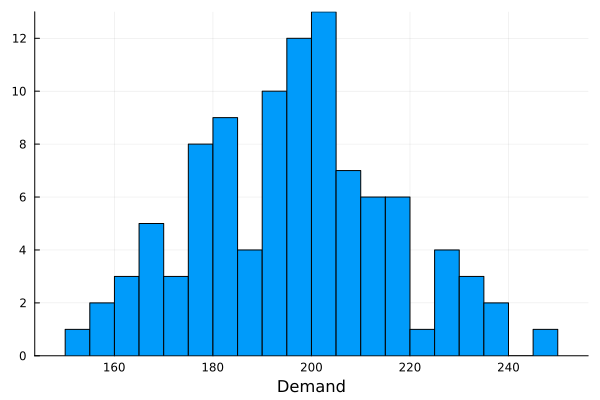

In [3]:
D = Distributions.TriangularDist(150.0, 250.0, 200.0) # Distribuição da demanda
N = 100 # Número de cenários
Ω = 1:N # Conjunto de cenários
P = fill(1 / N, N); # Probabilidade de cada cenário
d = sort!(rand(D, N)); # Demanda em cada cenário
StatsPlots.histogram(d; bins = 20, label = "", xlabel = "Demand")

### Modelo JuMP

A implementação de nosso programa estocástico de dois estágios em JuMP é:

In [4]:
model = Model(HiGHS.Optimizer)
set_silent(model)
@variable(model, x >= 0)
@variable(model, 0 <= y[ω in Ω] <= d[ω])
@constraint(model, [ω in Ω], y[ω] <= x)
@expression(model, z[ω in Ω], 5y[ω] - 0.1 * (x - y[ω])) # líquido das vendas menos descarte
@objective(model, Max, -2x + sum(P[ω] * z[ω] for ω in Ω))
optimize!(model)
solution_summary(model)

* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 5.50709e+02
  Objective bound    : 5.50709e+02
  Relative gap       : 4.12875e-16
  Dual objective value : 5.50709e+02

* Work counters
  Solve time (sec)   : 1.24190e-02
  Simplex iterations : 42
  Barrier iterations : 0
  Node count         : -1


O número ideal de tortas a fazer é:

In [5]:
value(x)

200.32758267867604

### Análise da solução

A distribuição do lucro total é:

In [6]:
lucro_total = [-2 * value(x) + value(z[ω]) for ω in Ω];

Vamos plotar isso:

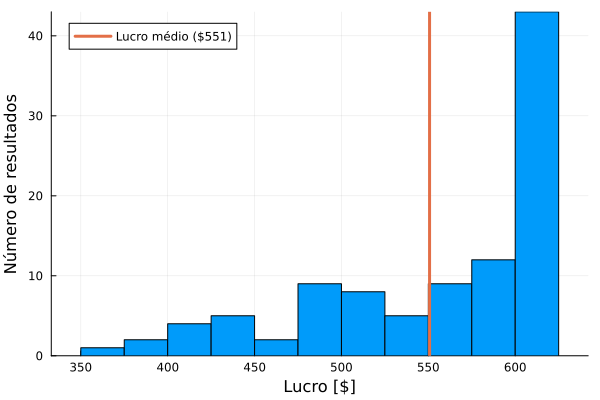

In [7]:
"""
    make_bins(x::Vector{T<:Real}, w)

Uma função auxiliar que discretiza o suporte de `x` em intervalos de largura `w`.
"""
make_bins(x, w) = w * (floor(minimum(x) / w):ceil(maximum(x) / w))

plot = StatsPlots.histogram(
    lucro_total;
    bins = make_bins(lucro_total, 25),
    label = "",
    xlabel = "Lucro [\$]",
    ylabel = "Número de resultados",
)
μ = Statistics.mean(lucro_total)
Plots.vline!(
    plot,
    [μ];
    label = "Lucro médio (\$$(round(Int, μ)))",
    linewidth = 3,
)
plot

## Medidas de Risco

Uma **medida de risco** é uma função que transforma uma variável aleatória $Z$ em um número real.
Medidas comuns de risco incluem a média (esperança), mediana, moda e máximo.

Uma medida de risco, assim como a média, converte a _distribuição_ dos custos
da segunda etapa em _um único número_ que pode ser otimizado.

Uma medida de risco popular é o valor condicional ao risco (CVaR).
O CVaR possui um parâmetro $\gamma \in [0,1]$ e calcula a média dos $\gamma$ piores resultados.
- Se $\gamma = 1$, o CVaR é o valor esperado
- Se $\gamma = 0$, o CVaR é o pior valor (que pode ser o mínimo ou o máximo, dependendo de estarmos maximizando ou minimizando)

In [8]:
function cvar(Z::Vector{Float64}, P::Vector{Float64}; γ::Float64, right_tail::Bool = false)
    n = length(Z)
    @assert length(P) == n

    I = sortperm(Z, rev = right_tail)
    acc = 0.0
    acc_p = 0.0
    i = popfirst!(I)
    while !isempty(I) && acc_p + P[i] <= γ
        acc += P[i] * Z[i]
        acc_p += P[i]
        i = popfirst!(I)
    end
    rem_prob = γ - acc_p
    return (acc + (rem_prob * Z[i])) / γ
end

cvar (generic function with 1 method)

Quando `γ` é `1.0`, calculamos a média do lucro:

In [9]:
cvar_10 = cvar(lucro_total, P; γ = 1.0)

550.708737487926

In [10]:
Statistics.mean(lucro_total)

550.7087374879262

À medida que `γ` se aproxima de `0.0`, calculamos o pior caso (lucro mínimo):

In [11]:
cvar_00 = cvar(lucro_total, P; γ = 0.0001)

362.54015036044257

In [12]:
minimum(lucro_total)

362.54015036044257

Ao variar `γ` entre `0` e `1`, podemos calcular um equilíbrio entre esses dois
extremos:

In [13]:
cvar_05 = cvar(lucro_total, P; γ = 0.5)

501.32581292258345

Vamos plotar esses resultados em nossa distribuição:

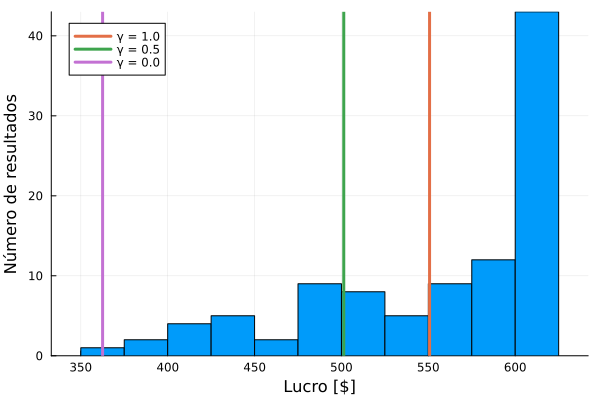

In [14]:
plot = StatsPlots.histogram(
    lucro_total;
    bins = make_bins(lucro_total, 25),
    label = "",
    xlabel = "Lucro [\$]",
    ylabel = "Número de resultados",
)
Plots.vline!(
    plot,
    [cvar_10 cvar_05 cvar_00];
    label = ["γ = 1.0" "γ = 0.5" "γ = 0.0"],
    linewidth = 3,
)
plot

O CVaR é interessante porque é fácil de calcular, _especialmente_ para otimização.

De fato, para o nosso caso de um problema de maximização (onde resultados pequenos são ruins), também podemos calcular o CVaR através de um problema de otimização:
$$
\text{CVaR}_{\gamma}[Z] = \max\limits_{\xi} \;\; \xi - \frac{1}{\gamma}\mathbb{E}_\omega\left[(\xi - Z)_+\right]
$$
que pode ser reformulado como um problema linear com a variável auxiliar $u_\omega$:
$$
\begin{aligned}
\text{CVaR}_{\gamma}[Z] = \max\limits_{\xi, u_\omega} \;\; & \xi - \frac{1}{\gamma}\sum P_\omega u_\omega\\
 & u_\omega \ge \xi - Z_\omega & \quad \forall \omega \in \Omega \\
 & u_\omega \ge 0 & \quad \forall \omega \in \Omega\rlap{.}
\end{aligned}
$$

In [15]:
function CVaR(Z::Vector{Float64}, P::Vector{Float64}; γ::Float64)
    @assert 0 < γ <= 1
    N = length(Z)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, ξ)
    @variable(model, u[1:N] >= 0)
    @constraint(model, [i in 1:N], u[i] >= ξ - Z[i])
    @objective(model, Max, ξ - 1 / γ * sum(P[i] * u[i] for i in 1:N))
    optimize!(model)
    return objective_value(model)
end

CVaR (generic function with 1 method)

In [16]:
cvar(lucro_total, P; γ = 0.5) ≈ CVaR(lucro_total, P; γ = 0.5)

true

### Aversão a risco e SAA

Como o CVaR pode ser formulado como um problema de otimização linear, podemos "juntar" esta parte ao modelo de otimização com cenários amostrados por SAA:

$$
\begin{aligned}
\max\limits_{x,y_\omega} \;\; & -2x + \text{CVaR}_\gamma[5y_\omega - 0.1(x - y_\omega)] \\
  & y_\omega \le x              & \quad \forall \omega \in \Omega \\
  & 0 \le y_\omega \le d_\omega & \quad \forall \omega \in \Omega \\
  & x \ge 0.
\end{aligned}
$$

$$
\begin{aligned}
\text{CVaR}_{\gamma}[Z] = \max\limits_{\xi, u_\omega} \;\; & \xi - \frac{1}{\gamma}\sum P_\omega u_\omega\\
 & u_\omega \ge \xi - Z_\omega & \quad \forall \omega \in \Omega \\
 & u_\omega \ge 0 & \quad \forall \omega \in \Omega\rlap{.}
\end{aligned}
$$

In [17]:
γ = 0.5
model = Model(HiGHS.Optimizer)
set_silent(model)

# Problema original: decisão x, variável de recurso y, custo em cada cenário Z
@variable(model, x >= 0)
@variable(model, 0 <= y[ω in Ω] <= d[ω])
@constraint(model, [ω in Ω], y[ω] <= x)
@expression(model, Z[ω in Ω], 5 * y[ω] - 0.1(x - y[ω]))

# Problema do CVaR: variáveis auxiliares ξ, e u
@variable(model, ξ)
@variable(model, u[ω in Ω] >= 0)
@constraint(model, [ω in Ω], u[ω] >= ξ - Z[ω])

# Função objetivo: custo de hoje (2x) + CVaR do custo futuro
@objective(model, Max, -2x + ξ - 1 / γ * sum(P[ω] * u[ω] for ω in Ω))
optimize!(model)

Quando $\gamma = 0.5$, o número ótimo de tortas a assar é:

In [18]:
value(x)

184.99804163875626

A distribuição do lucro total é:

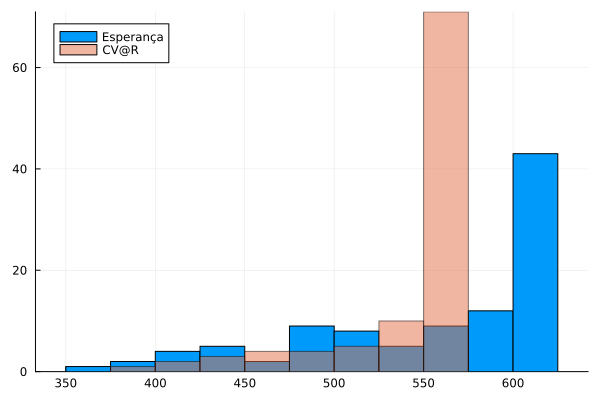

In [19]:
lucro_total_averso_a_risco = [value(-2x + Z[ω]) for ω in Ω]
bins = make_bins([lucro_total; lucro_total_averso_a_risco], 25)
plot = StatsPlots.histogram(lucro_total; label = "Esperança", bins = bins)
StatsPlots.histogram!(
    plot,
    lucro_total_averso_a_risco;
    label = "CV@R",
    bins = bins,
    alpha = 0.5,
)
plot

## Próximos passos

 * Resolva esse problema para diferentes números de amostras e diferentes distribuições.
 * Refatore o exemplo para não fixar os custos. O que acontece se o custo
   de descarte (das tortas não vendidas) aumentar?
 * Plote o número ótimo de tortas a fazer para diferentes valores do parâmetro
   de aversão a risco $\gamma$. Qual é a relação?

## Escrevendo o modelo por partes

Uma das vantagens de `JuMP` é a capacidade de escrever modelos em partes.
Assim, podemos ter funções separadas para representar diferentes componentes de um problema de otimização.

A ferramenta fundamental para este tipo de modelagem é a capacidade de retornar variáveis que representam _expressões_ matemáticas construídas em uma função para serem utilizadas em outras, e não apenas variáveis e restrições.

In [20]:
γ = 0.5
model = Model(HiGHS.Optimizer)
set_silent(model)

function build(model)
    # Problema original: decisão x, variável de recurso y, custo em cada cenário Z
    @variable(model, x >= 0)
    @variable(model, 0 <= y[ω in Ω] <= d[ω])
    @constraint(model, [ω in Ω], y[ω] <= x)
    @expression(model, Z[ω in Ω], 5 * y[ω] - 0.1(x - y[ω]))
    return (x=x, y=y, Z=Z)
end

function apply_cvar(model, Z, γ)
    # Problema do CVaR: variáveis auxiliares ξ, e u
    @variable(model, ξ)
    @variable(model, u[ω in Ω] >= 0)
    @constraint(model, [ω in Ω], u[ω] >= ξ - Z[ω])
    # O "CVaR" não é nem uma variável de decisão
    # nem uma restrição do problema,
    # mas uma parte da função objetivo.
    @expression(model, cvar, ξ - 1 / γ * sum(P[ω] * u[ω] for ω in Ω))
    return cvar
end

x, y, Z = build(model)
cvar_Z = apply_cvar(model, Z, γ)

# Função objetivo: custo de hoje (2x) + CVaR do custo futuro
@objective(model, Max, -2x + cvar_Z)
optimize!(model)